In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


In [2]:
from src.model import SSCNetwork
from Network_Definition.forward import forward
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network

In [3]:
network_parameters = {}

###################
#general paramerers
###################

#network regions
network_parameters["regions"] = ["hidden", "output"]

#number of pattern complete operations
network_parameters["hidden_pattern_complete_iterations"] = 10

##################
#region parameters
##################

network_parameters["hidden_num_subregions"] = 1
network_parameters["hidden_size_subregions"] = torch.tensor([100])
network_parameters["hidden_sparsity"] = torch.tensor([0.2])
network_parameters["hidden_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["output_num_subregions"] = 1
network_parameters["output_size_subregions"] = torch.tensor([50])
network_parameters["output_sparsity"] = torch.tensor([2/50])
network_parameters["hidden_sparsity_sleep"] = torch.tensor([2/50])


####################
#synaptic parameters
####################

network_parameters["connectivity"] = ["hidden_hidden", "output_hidden"]

#hidden_hidden
#init
network_parameters["hidden_hidden_init"] = "random"
network_parameters["hidden_hidden_init_random_max"] = "post"
network_parameters["hidden_hidden_init_max_post"] = 1
network_parameters["hidden_hidden_init_rf_size"] = 30
network_parameters["hidden_hidden_init_std"] = 0.0005
#learning
network_parameters["hidden_hidden_lmbda"] = 5e-4
network_parameters["max_pre_hidden_hidden"] = 1
network_parameters["max_post_hidden_hidden"] = np.inf

#output_hidden
#init
network_parameters["output_hidden_init"] = "random"
network_parameters["output_hidden_init_random_max"] = "post"
network_parameters["output_hidden_init_max_post"] = 1
network_parameters["output_hidden_init_rf_size"] = 10
network_parameters["output_hidden_init_std"] = 0.0005
#learning
network_parameters["output_hidden_lmbda"] = 5e-4
network_parameters["max_pre_output_hidden"] = np.inf
network_parameters["max_post_output_hidden"] = 1

In [4]:
network_model = {}
network_model["forward"] = forward

In [5]:
recording_parameters = {}
recording_parameters["regions"] = ["hidden", "output"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["hidden_hidden"]
recording_parameters["rate_connectivity"] = 100



input_params = {}
input_params["num_days"] = 500
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 0

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [6]:
input, input_episodes, input_latents = make_input(**input_params)

In [7]:
network = SSCNetwork(network_parameters, recording_parameters, network_model)

In [8]:
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0
50
100
150
200
250
300
350
400
450


Text(0.5, 0, 'Time')

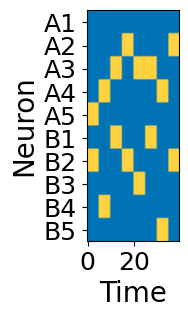

In [9]:


fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T, cmap=blue_yellow, vmin=0, vmax=1)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)



In [12]:
X_output = torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)
X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))

network.selectivity_output_episodes, network.ordered_indices_output_episodes = get_ordered_indices(X_output, X_episodes, assembly_size=10)


(array([13.,  0.,  2.,  4.,  9.,  8.,  7.,  1.,  4.,  2.]),
 array([0.        , 0.0999835 , 0.199967  , 0.29995048, 0.39993399,
        0.49991748, 0.59990096, 0.69988447, 0.79986799, 0.89985144,
        0.99983495]),
 <BarContainer object of 10 artists>)

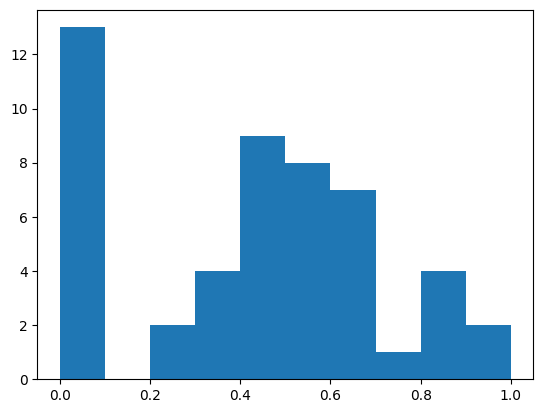

In [32]:
plt.hist(network.selectivity_output_episodes.max(axis=1)[0].flatten())

([<matplotlib.axis.YTick at 0x367fabd90>,
 [Text(0, 1.0, 'A1B1'),
  Text(0, 3.0, 'A1B2'),
  Text(0, 5.0, 'A1B3'),
  Text(0, 7.0, 'A1B4'),
  Text(0, 9.0, 'A1B5'),
  Text(0, 11.0, 'A2B1'),
  Text(0, 13.0, 'A2B2'),
  Text(0, 15.0, 'A2B3'),
  Text(0, 17.0, 'A2B4'),
  Text(0, 19.0, 'A2B5'),
  Text(0, 21.0, 'A3B1'),
  Text(0, 23.0, 'A3B2'),
  Text(0, 25.0, 'A3B3'),
  Text(0, 27.0, 'A3B4'),
  Text(0, 29.0, 'A3B5'),
  Text(0, 31.0, 'A4B1'),
  Text(0, 33.0, 'A4B2'),
  Text(0, 35.0, 'A4B3'),
  Text(0, 37.0, 'A4B4'),
  Text(0, 39.0, 'A4B5'),
  Text(0, 41.0, 'A5B1'),
  Text(0, 43.0, 'A5B2'),
  Text(0, 45.0, 'A5B3'),
  Text(0, 47.0, 'A5B4'),
  Text(0, 49.0, 'A5B5')])

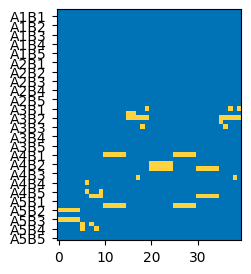

In [30]:


fig = plt.figure(figsize=(3, 3))

plt.imshow(torch.stack(network.activity_recordings["output"], dim=0)[network.awake_indices][:input_params["day_length"]//2, network.ordered_indices_output_episodes[:50]].reshape(-1, 50).T, cmap=blue_yellow, vmin=0, vmax=1) 


# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes =  [M * (k + 0.5) for k in range(NA * NB)]



plt.yticks(positions_episodes, labels_episodes, fontsize=10)